In [2]:
import time
import hmac
import requests
import pandas as pd
from datetime import datetime
import urllib.parse
import asyncio
import matplotlib.pyplot as plt

In [3]:
class FTX_Client_Hicham:
    api_endpoint_base = "https://ftx.com/api/"

    def __init__(self,api_key:str,api_secret:str,subaccount:str=None):
        """Indiquer les clés API et éventuellement un subaccount"""
        self._session = requests.Session()
        self._api_key = api_key
        self._api_secret = api_secret
        self._subaccount = subaccount

    def get_open_orders(self):
        ''' Cette fonction permet de récupérer les ordres qui sont actuellement ouverts'''
        url = self.api_endpoint_base + "orders"
        request = requests.Request('GET', url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        if len(df_data)!=0:
            df_data.drop(['clientId','reduceOnly','liquidation','postOnly','ioc',"future","createdAt","avgFillPrice","remainingSize","filledSize"],axis=1,inplace=True) 
            df_data.set_index("id",inplace=True)    
        return df_data

    def get_positions(self):
        """Cette fonction permet de récupérer les positions actuellement ouvertes sur des contrats futures"""
        url = self.api_endpoint_base + "positions"
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        return df_data[df_data["size"]>0]

    def cancel_order(self,order_id):
        """ Cette fonction permet d'annuler un ordre s'il n'a pas déjà été exécuté, l'ID de l'ordre est obtenu dans le résultat de la fonction send_order"""
        url = self.api_endpoint_base + "orders/" + str(order_id)
        request = requests.Request('DELETE',url)
        data = self.send_request(request)
        #df_data = pd.DataFrame(data)
        return data

    def get_order_status(self,order_id):
        """ Cette fonction permet de récupérer le statut d'un ordre"""
        url = self.api_endpoint_base + "orders/" + str(order_id)
        request = requests.Request("GET",url)
        data = self.send_request(request)
        return data

    def get_balances(self):
        """ Cette fonction permet de récupérer le solde du compte"""
        url = self.api_endpoint_base + "wallet/balances"
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        return df_data[df_data["total"]>0]

    def get_order_history(self):
        """ Cette fonction permet de récupérer l'historique des ordres passés (sans forcément avoir été exécutés)"""
        url = self.api_endpoint_base + "orders/history"
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)     
        return df_data   

    def get_last_n_funding_rates(self,market,n):
        ''' Cette fonction permet de récupérer les n derniers funding rates sur un future perp'''
        url = self.api_endpoint_base + "funding_rates?future=" + market
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        df_data.set_index("time",inplace=True)
        return df_data[:n]['rate'].to_numpy()

    def send_order(self,market:str,side:str,price:str,type:str,size:str):
        """ Cette fonction permet d'envoyer un ordre:
        market : paire (BTC/USD) ou future (BTC-PERP)      
        side: buy ou sell
        price: prix (mettre 0 pour un ordre market)
        type: limit ou market
        size: quantité
        return: renvoie un récapitulatif de l'ordre passé contenant notamment son ID 
        """
        url = self.api_endpoint_base + "orders"
        params = {"market":market,"side":side,"price":price,"type":type,"size":size,"postOnly":True}
        request = requests.Request("POST",url,json=params)
        data = self.send_request(request)
        return data

    def process_response(self,response):
        ''' Cette fonction sert à traiter la réponse du serveur FTX'''
        try:
            data = response.json()
        except ValueError:
            response.raise_for_status()
            raise
        else:
            if not data['success']:
                raise Exception(data['error'])
            return data['result']

    def send_request(self,request):
        """ Cette fonction sert à envoyer les requêtes au serveur FTX"""
        ts = int(time.time() * 1000)
        prepared = request.prepare()

        signature_payload = f'{ts}{prepared.method}{prepared.path_url}'.encode()

        if prepared.body:
            signature_payload += prepared.body

        signature = hmac.new(self._api_secret.encode(), signature_payload, 'sha256').hexdigest()

        prepared.headers[f'FTX-KEY'] = self._api_key
        prepared.headers[f'FTX-SIGN'] = signature
        prepared.headers[f'FTX-TS'] = str(ts)
        if self._subaccount :
            prepared.headers[f'FTX-SUBACCOUNT'] = urllib.parse.quote(self._subaccount)

        response = self._session.send(prepared)
        return self.process_response(response) 
    
    def get_live_quote(self,market:str):
        """Permet d'avoir les quotes pour les spots et les futures, par ex: get_quote("BTC/USD") ou get_quote("BTC-PERP")"""
        url = self.api_endpoint_base + "markets/" + market
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame.from_dict(data,orient="index")
        return df_data

    def get_historical_data_start_end(self,market:str,resolution:int,start_time:str,end_time:str):
        """Permet d'avoir les données historiques sur une paire spot ou sur un future, la résolution est à indiquer en secondes"""
        url = self.api_endpoint_base + "markets/" + market + "/candles?resolution=" + str(resolution) +"&start_time=" + start_time + "&end_time=" + end_time
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        df_data['date'] = pd.to_datetime(df_data["time"]/1000,unit='s',origin='unix')
        df_data.drop(['startTime','time'],axis=1,inplace=True)  
        df_data.set_index('date',inplace=True)
        return df_data

    def get_historical_data(self,market:str,resolution:int,number:int):
        """Permet d'avoir les données historiques sur une paire spot ou sur un future, la résolution est à indiquer en secondes"""
        url = self.api_endpoint_base + "markets/" + market + "/candles?resolution=" + str(resolution) +"&limit=" + str(number)
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        df_data['date'] = pd.to_datetime(df_data["time"]/1000,unit='s',origin='unix')
        df_data.drop(['startTime','time'],axis=1,inplace=True)  
        df_data.set_index('date',inplace=True)
        return df_data

    def get_last_n_minutes_future_spot_spread(self,market_fut:str,market_spot:str,n:int):
        """Permet d'avoir le spread entre un future et le spot associé pour les n dernières minutes"""
        fut = self.get_historical_data(market_fut,60,n)
        spot = self.get_historical_data(market_spot,60,n)
        return ((fut-spot)/spot)["close"]

    def get_last_n_hours_first_second_spread(self,first_market:str,second_market:str,n:int):
        """Permet d'avoir le spread entre deux machés"""
        first = self.get_historical_data(first_market,60*60,n)
        second = self.get_historical_data(second_market,60*60,n)
        return (first/second - 1)['close']

    def get_futures(self):
        url = self.api_endpoint_base + "futures"
        request = requests.Request("GET",url)
        data = self.send_request(request)
        df_data = pd.DataFrame(data)
        return df_data

    def get_top_n_futures_by_volume(self,n):
        return self.get_futures().sort_values("volumeUsd24h",ascending=False)[:n]

    def get_available_opportunities(self):
        top_50_futures = self.get_top_n_futures_by_volume(30)
        Coins = top_50_futures["underlying"]
        Opportunities = []
        for coin in Coins :
            try : 
                if (self.get_last_n_minutes_future_spot_spread(coin+"-PERP",coin+"/USD",5)>0).all() == True:
                    Opportunities.append(coin)
            except :
                pass
        return Opportunities


In [4]:
class Trader :

    def __init__(self,client):
        self.client = client

    def balances(self):
        client = self.client
        return client.get_balances()

    def enter_trade_conditions(self,spot_market,fut_market):
        """On récupère le spread future spot des 5 dernières minutes et on compare avec le spread actuel"""
        client = self.client
        spreads = client.get_last_n_minutes_future_spot_spread(fut_market,spot_market,6)
        SMA_spread = spreads[:5].mean()
        current_spread = spreads[-1]
        if current_spread > 0 and current_spread > SMA_spread and (spreads>0).all() : 
            return True 
        else :
            return False

    def enter_trade(self,spot_market,fut_market,amount):
        client = self.client
        """amount : Montant de la pos en USD"""
        """seuil : seuil de temps avant de retirer l'ordre s'il n'est pas passé"""

        bid_price_spot = client.get_live_quote(spot_market)[0]["bid"]

        size = amount/bid_price_spot

        """On envoie l'ordre spot"""
        spot_order = client.send_order(spot_market,"buy",bid_price_spot,"limit",size)
        print("ordre spot envoyé")

        chrono = time.time()
        print("chrono lancé")

        '''On vérifie si l'ordre est passé'''

        while time.time()-chrono <= 25.00 : 

            order_status_dict = client.get_order_status(spot_order["id"])

            if order_status_dict["status"] == "closed" and order_status_dict["filledSize"] <=0:
                order_status = "cancelled"

            elif order_status_dict["status"] == "closed" and order_status_dict["filledSize"]>0:
                order_status = "filled"

            elif order_status_dict["status"] == "open" :
                order_status = "open"

            else :
                return "Error sur l'order status"


            if order_status == "cancelled" :
                print("l'ordre a été cancelled")
                spot_order = client.send_order(spot_market,"buy",bid_price_spot,"limit",size)
                print("ordre relancé")
                chrono = time.time()
                print("chrono relancé")

            elif order_status == "filled":
                print("ordre filled")
                break

            elif order_status == "open":
                pass


        if time.time()-chrono > 25.00 and order_status == "open" :
            print("ordre pas passé au bout de 25 secondes")
            client.cancel_order(spot_order["id"])
            return "Error"

        print("Long spot")

        ask_price_future = client.get_live_quote(fut_market)[0]["ask"]

        while ask_price_future <= bid_price_spot:
            ask_price_future = client.get_live_quote(fut_market)[0]["ask"]

        fut_order = client.send_order(fut_market,"sell",ask_price_future,"limit",size)
        print("ordre fut envoyé")

        while True :
            order_status_dict = client.get_order_status(fut_order["id"])

            if order_status_dict["status"] == "closed" and order_status_dict["filledSize"] <=0:
                order_status = "cancelled"
                
            elif order_status_dict["status"] == "closed" and order_status_dict["filledSize"]>0:
                order_status = "filled"

            elif order_status_dict["status"] == "open" :
                order_status = "open"

            else :
                return "Error sur l'order status"

            if order_status == "cancelled":
                print("ordre fut cancelled")
                fut_order = client.send_order(fut_market,"sell",ask_price_future,"limit",size)
                print('ordre fut renvoyé')

            elif order_status == "filled":
                print("ordre fut filled")
                break

        print("Short future")

        return size

    def close_trade_conditions(self,spot_market,fut_market):
        """On récupère le spread future spot des 5 dernières minutes et on compare avec le seuil voulu"""
        client = self.client
        spreads = client.get_last_n_minutes_future_spot_spread(fut_market,spot_market,5)
        if (spreads< 0).all() == True : 
            return True 
        else :
            return False

    def close_trade(self,spot_market,fut_market,size):

        client = self.client

        bid_price_future = client.get_live_quote(fut_market)[0]["bid"]
        

        fut_order = client.send_order(fut_market,"buy",bid_price_future,"limit",size)

        chrono = time.time()

        while time.time()-chrono <= 25.00 : 
            order_status_dict = client.get_order_status(fut_order["id"])

            if order_status_dict["status"] == "closed" and order_status_dict["filledSize"] <=0:
                order_status = "cancelled"
                
            elif order_status_dict["status"] == "closed" and order_status_dict["filledSize"]>0:
                order_status = "filled"

            elif order_status_dict["status"] == "open" :
                order_status = "open"

            else :
                return "Error sur l'order status"

            if order_status == "cancelled":
                fut_order = client.send_order(fut_market,"buy",bid_price_future,"limit",size)
                chrono = time.time()

            elif order_status == "filled":
                break

            elif order_status == "open":
                pass


        if time.time()-chrono > 25.00 and order_status =="open" :
            client.cancel_order(fut_order["id"])
            return "Error"

        print("Long future")

        ask_price_spot = client.get_live_quote(spot_market)[0]["ask"]

        while ask_price_spot <= bid_price_future :
            ask_price_spot = client.get_live_quote(spot_market)[0]["ask"]
        
        spot_order = client.send_order(spot_market,"sell",ask_price_spot,"limit",size)
        
        while True :
            order_status_dict = client.get_order_status(spot_order["id"])

            if order_status_dict["status"] == "closed" and order_status_dict["filledSize"] <=0:
                order_status = "cancelled"
                
            elif order_status_dict["status"] == "closed" and order_status_dict["filledSize"]>0:
                order_status = "filled"

            elif order_status_dict["status"] == "open" :
                order_status = "open"

            else :
                return "Error sur l'order status"

            if order_status == "cancelled":
                spot_order =  client.send_order(spot_market,"sell",ask_price_spot,"limit",size)

            elif order_status == "filled":
                break

        print("Short spot")
        
        return "OK"


    def trade_routine(self,spot_market,fut_market,amount):

        client = self.client
        currently_in_trade = False   
        Trading = True

        while Trading ==True :
        
            while currently_in_trade == False and self.enter_trade_conditions(spot_market,fut_market) == True: 
                trade_size = self.enter_trade(spot_market,fut_market,amount)
                if trade_size == 'Error':
                    print("Order cancelled")
                else: 
                    currently_in_trade = True
                    print("Actuellement en trade")
                    break
            
            while currently_in_trade == True and self.close_trade_conditions(spot_market,fut_market) == True:
                trade = self.close_trade(spot_market,fut_market,trade_size)
                if trade == "Error":
                    print("order cancelled")
                else : 
                    currently_in_trade = False
                    Trading = False
                    print("Sorti du trade")
                    break

            if currently_in_trade == True :
                time.sleep(120)
            else : 
                time.sleep(30)

        return "Trade effectué correctement"

In [94]:
client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
client.get_available_opportunities()

['XRP']

In [99]:
client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
client.get_last_n_minutes_future_spot_spread("btc-perp","btc/usd",6)

date
2022-06-27 07:59:00    0.000422
2022-06-27 08:00:00    0.000328
2022-06-27 08:01:00    0.000140
2022-06-27 08:02:00    0.000281
2022-06-27 08:03:00    0.000140
2022-06-27 08:04:00    0.000094
Name: close, dtype: float64

In [21]:


currently_in_trade = False

while True : 

    client = FTX_Client_Hicham(api_key,api_secret,"Trading")
    trade = Trader(client)
    
    spreads = client.get_last_n_minutes_future_spot_spread("eth/usd","steth/usd",11)[:-1]
    ten_last_spreads = spreads[:-1]
    last_spread = spreads[-1]

    print(last_spread, ten_last_spreads.mean() + 1.5*ten_last_spreads.std())
    while currently_in_trade == False and last_spread > ten_last_spreads.mean() + 1.5*ten_last_spreads.std() :
        size = trade.enter_trade("steth/usd","eth-perp",20)
        
        if size == "Error":
            print("order cancelled")
        else :
            currently_in_trade = True
            trade_spread = last_spread
            print("En trade")
            break

    while currently_in_trade == True and last_spread < trade_spread*0.8 :
        close_trade = trade.close_trade("steth/usd","eth-perp",size)
        
        if close_trade == "Error":
            print("order cancelled")
        else :
            currently_in_trade = False 
            print("sorti")
            break

    if currently_in_trade == True :
        time.sleep(120)
    else : 
        time.sleep(30)




0.0523502304147465 0.05173362670124089


Exception: Not enough balances

In [12]:
client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
#btc = client.get_historical_data("btc/usd",3600,str(int(time.time()-1501*3600)),str(int(time.time())))["close"]
#btc_1 = client.get_historical_data("btc/usd",3600,str(int(time.time()-3001*3600)),str(int(time.time()-1500*3600)))["close"]

"""Boucle pour choper la data hourly depuis longtemps ++"""
btc_price = pd.Series()
for i in range(0,-1,-1):
    btc_tmp = client.get_historical_data_start_end("btc/usd",3600,str(int(time.time()-(1+(i+1)*1500)*3600)),str(int(time.time()-(1500*i)*3600)))["close"]
    btc_price = btc_price.append(btc_tmp)
    
btc_price.to_excel("check_strat.xlsx")

C:\Users\HICHAM~1.BOU\AppData\Local\Temp/ipykernel_4124/1734744773.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  btc_price = pd.Series()


<AxesSubplot:xlabel='date'>

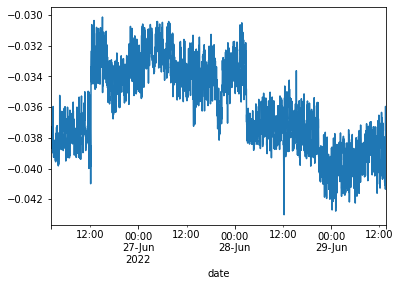

In [9]:
client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
client.get_last_n_minutes_future_spot_spread("steth/usd","eth/usd",50000).plot()

In [11]:
alt_perp = client.get_historical_data("alt-perp",3600,20000)["close"]
alt_perp.to_excel("perp.xlsx")

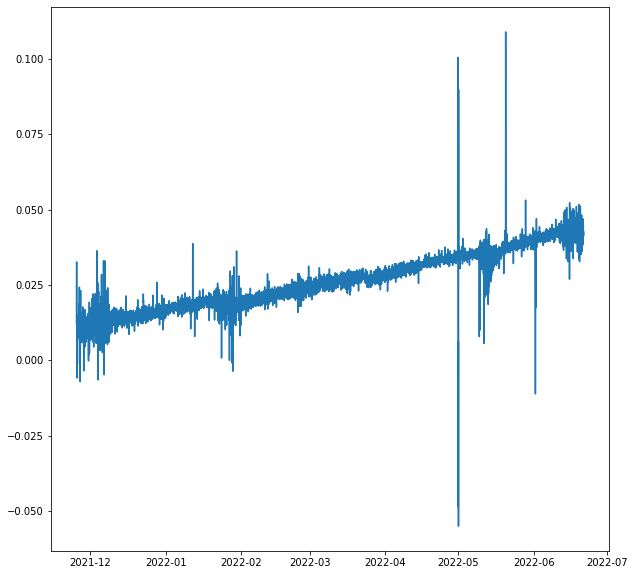

In [24]:
fig = plt.figure(figsize=(10,10))
plt.plot((steth/eth-1))
plt.show()

In [100]:
client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
trader = Trader(client)
trader.trade_routine("btc/USD","btc-PERP",45)

ordre spot envoyé
chrono lancé
ordre pas passé au bout de 25 secondes
Order cancelled
ordre spot envoyé
chrono lancé
ordre filled
Long spot
ordre fut envoyé
ordre fut filled
Short future
Actuellement en trade


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [101]:
trader.close_trade("btc/usd","btc-perp",0.0021000)

Long future
Short spot


'OK'

In [33]:
"""Arbitrage STSol/SOL Test """

currently_in_trade = False
amount = 45

while True : 

    client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
    trade = Trader(client)
    
    spreads = client.get_last_n_hours_first_second_spread("stsol/usd","sol/usd",11)
    ten_last_spreads = spreads[:-1]
    last_spread = spreads[-1]

    while currently_in_trade == False and last_spread < ten_last_spreads.mean() + ten_last_spreads.std() :
        size = trade.enter_trade("stsol/usd","sol/usd",amount)
        
        if size == "Error":
            print("order cancelled")
        else :
            currently_in_trade = True
            trade_spread = last_spread
            print("En trade")
            break

    while currently_in_trade == True and last_spread >= ten_last_spreads.mean() + ten_last_spreads.std() :
        close_trade = trade.close_trade("stsol/usd","sol/usd",size)
        
        if close_trade == "Error":
            print("order cancelled")
        else :
            currently_in_trade = False 
            print("sorti")
            break

    if currently_in_trade == True :
        time.sleep(3600)
    else : 
        time.sleep(3600)



ordre spot envoyé
chrono lancé
ordre pas passé au bout de 25 secondes
order cancelled
ordre spot envoyé
chrono lancé
ordre pas passé au bout de 25 secondes
order cancelled
ordre spot envoyé
chrono lancé
ordre pas passé au bout de 25 secondes
order cancelled
ordre spot envoyé
chrono lancé
ordre pas passé au bout de 25 secondes
order cancelled
ordre spot envoyé
chrono lancé
ordre pas passé au bout de 25 secondes
order cancelled
ordre spot envoyé
chrono lancé
ordre filled
Long spot


KeyboardInterrupt: 

In [31]:
client = FTX_Client_Hicham(api_key,api_secret,"BotArb")
spreads = client.get_last_n_hours_first_second_spread("stsol/usd","sol/usd",11)
ten_last_spreads = spreads[:-1]
last_spread = spreads[-1]
print(last_spread)
print(ten_last_spreads.mean()-ten_last_spreads.std())

0.039830126761469575
0.040142804549377145
